<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_6_Wac2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1. Install Necessary Libraries ---
!pip install transformers datasets evaluate soundfile librosa torchaudio accelerate pandas -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor, AutoModel
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 705.9 kB/s eta 0:00:00


## **ARC LAB RAVDESS**

In [ ]:
import os
import pandas as pd

# Path to data
ravdess = "/content/drive/MyDrive/DeepLearning/External/RAVDESS Emotional Speech Audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

file_emotion = []
file_path = []
file_speaker = []  # <--- NEW LIST for Speaker IDs

for i in ravdess_directory_list:
    # as there are 24 different actors in our previous directory we need to extract files for each actor.
    actor_path = os.path.join(ravdess, i)

    # Check if it is a directory to avoid errors with random files
    if os.path.isdir(actor_path):
        actor_files = os.listdir(actor_path)

        for f in actor_files:
            # Filename example: 03-01-06-01-02-01-12.wav
            part = f.split('.')[0].split('-')

            # 3rd part (index 2) is Emotion
            file_emotion.append(int(part[2]))

            # 7th part (index 6) is Actor ID <--- EXTRACTION HERE
            file_speaker.append(int(part[6]))

            file_path.append(os.path.join(actor_path, f))

# DataFrame for emotion
emotion_df = pd.DataFrame(file_emotion, columns=['emotion'])

# DataFrame for paths
path_df = pd.DataFrame(file_path, columns=['path'])

# DataFrame for speakers <--- NEW COLUMN
speaker_df = pd.DataFrame(file_speaker, columns=['speaker'])

# Concatenate all
ravdess_df = pd.concat([emotion_df, speaker_df, path_df], axis=1)

# Changing integers to actual emotions
ravdess_df.emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.emotion.value_counts())
print("\nSpeaker Counts:")
print(ravdess_df['speaker'].value_counts().sort_index()) # Check if you have all 24 actors

# Save the processed DataFrame with Speakers to CSV
ravdess_df.to_csv('/content/ravdess_processed.csv', index=False)

['Actor_07', 'Actor_09', 'Actor_08', 'Actor_06', 'Actor_01', 'Actor_24', 'Actor_13', 'Actor_22', 'Actor_03', 'Actor_05', 'Actor_14', 'Actor_15', 'Actor_12', 'Actor_02', 'Actor_23', 'Actor_20', 'Actor_21', 'Actor_17', 'Actor_10', 'Actor_04', 'Actor_11', 'Actor_16', 'Actor_19', 'Actor_18']
   emotion  speaker                                               path
0    happy        7  /content/drive/MyDrive/DeepLearning/External/R...
1      sad        7  /content/drive/MyDrive/DeepLearning/External/R...
2     fear        7  /content/drive/MyDrive/DeepLearning/External/R...
3  disgust        7  /content/drive/MyDrive/DeepLearning/External/R...
4    angry        7  /content/drive/MyDrive/DeepLearning/External/R...
______________________________________________
       emotion  speaker                                               path
1435     angry       18  /content/drive/MyDrive/DeepLearning/External/R...
1436      fear       18  /content/drive/MyDrive/DeepLearning/External/R...
1437       sa

/tmp/ipython-input-1733908336.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


In [ ]:
import pandas as pd
import os

CSV_PATH = '/content/ravdess_processed.csv'

NEW_AUDIO_BASE_PATH = '/content/audio_speech_actors_01-24/'

print(f"Loading DataFrame from: {CSV_PATH}")

try:
    ravdess_df = pd.read_csv(CSV_PATH)
    print("DataFrame loaded successfully.")
    print("Original path examples:")
    print(ravdess_df['path'].head())

    def update_local_path(original_path):
        parts = original_path.split(os.sep)
        actor_folder = parts[-2]
        filename = parts[-1]

        return os.path.join(NEW_AUDIO_BASE_PATH, actor_folder, filename)

    ravdess_df['path'] = ravdess_df['path'].apply(update_local_path)

    print("\nFile paths updated successfully for local environment.")
    print("New path examples:")
    print(ravdess_df['path'].head())

    NEW_CSV_PATH = '/content/ravdess_local_paths.csv'
    ravdess_df.to_csv(NEW_CSV_PATH, index=False)
    print(f"\nUpdated DataFrame saved to: {NEW_CSV_PATH}")

except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_PATH}. Please ensure it has been generated and saved.")
except KeyError:
    print("Error: 'path' column not found in the DataFrame. Please check the CSV content.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading DataFrame from: /content/ravdess_processed.csv
DataFrame loaded successfully.
Original path examples:
0    /content/drive/MyDrive/DeepLearning/External/R...
1    /content/drive/MyDrive/DeepLearning/External/R...
2    /content/drive/MyDrive/DeepLearning/External/R...
3    /content/drive/MyDrive/DeepLearning/External/R...
4    /content/drive/MyDrive/DeepLearning/External/R...
Name: path, dtype: object

File paths updated successfully for local environment.
New path examples:
0    /content/audio_speech_actors_01-24/Actor_07/03...
1    /content/audio_speech_actors_01-24/Actor_07/03...
2    /content/audio_speech_actors_01-24/Actor_07/03...
3    /content/audio_speech_actors_01-24/Actor_07/03...
4    /content/audio_speech_actors_01-24/Actor_07/03...
Name: path, dtype: object

Updated DataFrame saved to: /content/ravdess_local_paths.csv


In [ ]:
import zipfile
import os

zip_file_path = '/content/audio_speech_actors_01-24.zip'
extract_dir = '/content/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipping complete. Audio files should now be in '/content/audio_speech_actors_01-24/'.")

Unzipping complete. Audio files should now be in '/content/audio_speech_actors_01-24/'.


# **GOOGLE DRIVE**

In [ ]:
CSV_PATH = '/content/ravdess_processed.csv'

# **ARC LAB**

In [ ]:
CSV_PATH = '/content/ravdess_local_paths.csv'

# **DATA SPLITTING**

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

TEST_SPEAKERS_STRICT = [21, 22, 23, 24]

def load_data_and_split(mode='random'):
    df = pd.read_csv(CSV_PATH)

    df.rename(columns={'Emotions': 'emotion', 'Path': 'path', 'Speaker': 'speaker'}, inplace=True)

    if mode == 'random':
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

    elif mode == 'strict':
        val_mask = df['speaker'].isin(TEST_SPEAKERS_STRICT)

        val_df = df[val_mask].copy()
        train_df = df[~val_mask].copy()

    else:
        raise ValueError("Mode must be 'random' or 'strict'")

    return train_df, val_df

if __name__ == "__main__":
    CURRENT_MODE = 'strict'

    train_df, val_df = load_data_and_split(CURRENT_MODE)

    if train_df is not None:
        df = pd.concat([train_df, val_df])

        label_list = sorted(df["emotion"].unique())
        num_labels = len(label_list)

        label2id = {label: i for i, label in enumerate(label_list)}
        id2label = {i: label for label, i in label2id.items()}


# **MODEL LOADING**

In [ ]:
import torch # Ensure torch is imported
from transformers import AutoFeatureExtractor, AutoModel

MODEL_NAME = "facebook/wav2vec2-base"

print(f"Loading feature extractor for {MODEL_NAME}...")
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
print("Feature extractor loaded.")

print(f"Loading full Wav2Vec2 model for {MODEL_NAME}...")
# Load the full model
wav2vec2_model = AutoModel.from_pretrained(MODEL_NAME)

# Move the model to GPU if available and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec2_model.to(device)

print(f"Full Wav2Vec2 model loaded and moved to {device}.")

Loading feature extractor for facebook/wav2vec2-base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Feature extractor loaded.
Loading full Wav2Vec2 model for facebook/wav2vec2-base...
Full Wav2Vec2 model loaded and moved to cuda.


# **FEATURE EXTRACTION**

In [ ]:
import numpy as np
import librosa
import torch
import pandas as pd
from tqdm.auto import tqdm

TARGET_SAMPLING_RATE = 16000
MAX_DURATION_SEC = 5
MAX_LENGTH = TARGET_SAMPLING_RATE * MAX_DURATION_SEC

def extract_features_to_arrays(dataframe, feature_extractor, model, label2id, device):
    features_list = []
    labels_list = []

    model.eval()
    model.to(device)

    print(f"Extracting features for {len(dataframe)} samples...")

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing Audio"):
        audio_path = row['path']
        label_str = row['emotion']

        try:
            audio_data, _ = librosa.load(audio_path, sr=TARGET_SAMPLING_RATE)

            inputs = feature_extractor(
                audio_data,
                sampling_rate=TARGET_SAMPLING_RATE,
                padding='max_length',
                max_length=MAX_LENGTH,
                truncation=True,
                return_tensors="pt"
            )

            input_values = inputs['input_values'].to(device)

            with torch.no_grad():
                outputs = model(input_values)
                hidden_states = outputs.last_hidden_state

            pooled_tensor = torch.mean(hidden_states, dim=1);

            pooled_np = pooled_tensor.squeeze(0).cpu().numpy()

            if label_str in label2id:
                features_list.append(pooled_np)
                labels_list.append(label2id[label_str])
            else:
                print(f"Warning: Label '{label_str}' not found in map. Skipping.")

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            continue

    return np.array(features_list), np.array(labels_list)

print("\n--- Processing Training Set ---")
train_features, train_labels = extract_features_to_arrays(
    train_df, feature_extractor, wav2vec2_model, label2id, device
)

print("\n--- Processing Validation Set ---")
val_features, val_labels = extract_features_to_arrays(
    val_df, feature_extractor, wav2vec2_model, label2id, device
)

print("\nSuccess!")
print(f"Train Features: {train_features.shape}")
print(f"Train Labels:   {train_labels.shape}")
print(f"Val Features:   {val_features.shape}")
print(f"Val Labels:     {val_labels.shape}")


--- Processing Training Set ---
Extracting features for 1200 samples...


Processing Audio:   0%|          | 0/1200 [00:00<?, ?it/s]


--- Processing Validation Set ---
Extracting features for 240 samples...


Processing Audio:   0%|          | 0/240 [00:00<?, ?it/s]


Success!
Train Features: (1200, 768)
Train Labels:   (1200,)
Val Features:   (240, 768)
Val Labels:     (240,)


# **FEED FORWARD NEURAL NETWORK**

Train Features: (1200, 768)
Train Labels: (1200,)


Model: "Wav2Vec_FFN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 794,631 (3.03 MB)

 Trainable params: 794,631 (3.03 MB)

 Non-trainable params: 0 (0.00 B)


Starting Training...
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2550 - loss: 1.8429 - val_accuracy: 0.2792 - val_loss: 1.7119
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3991 - loss: 1.5815 - val_accuracy: 0.2875 - val_loss: 1.7554
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4171 - loss: 1.4890 - val_accuracy: 0.3167 - val_loss: 1.6476
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4729 - loss: 1.3876 - val_accuracy: 0.4208 - val_loss: 1.4876
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 1.3137 - val_accuracy: 0.4000 - val_loss: 1.5270
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5582 - loss: 1.2229 - val_accuracy: 0.3792 - val_loss: 1.5932
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5762 - loss: 1.1848 - val_accuracy: 0.5167 - val_loss: 1.3783
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5777 - loss: 1.1843 - v

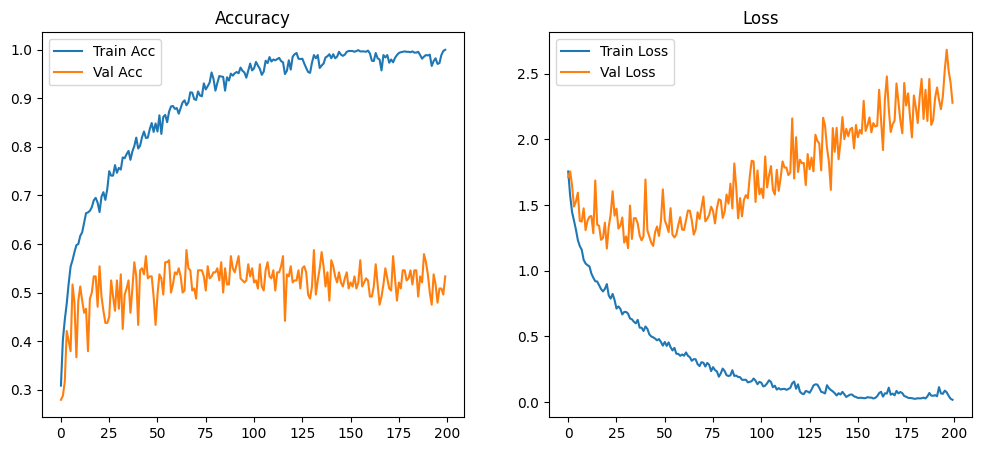


--- Final Evaluation on Validation Set ---
Validation Accuracy: 53.33%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.67        32
           1       0.50      0.41      0.45        32
           2       0.76      0.41      0.53        32
           3       0.35      0.56      0.43        32
           4       0.69      0.60      0.64        48
           5       0.50      0.41      0.45        32
           6       0.49      0.53      0.51        32

    accuracy                           0.53       240
   macro avg       0.55      0.53      0.53       240
weighted avg       0.56      0.53      0.53       240



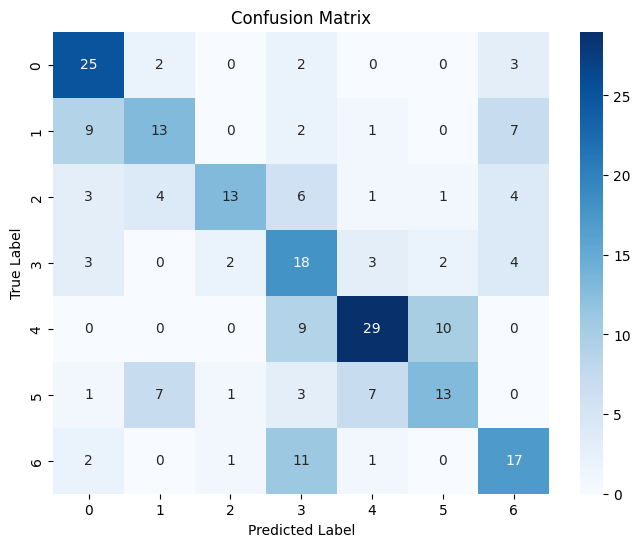

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 1e-3
INPUT_DIM = 768
HIDDEN_DIM = 512*2
NUM_CLASSES = 7

def build_emotion_classifier(input_dim, hidden_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))

    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)


    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Wav2Vec_FFN_Classifier")
    return model


if __name__ == "__main__":

    train_features_np = train_features
    train_labels_np = train_labels
    val_features_np = val_features
    val_labels_np = val_labels

    print(f"Train Features: {train_features_np.shape}")
    print(f"Train Labels: {train_labels_np.shape}")

    model = build_emotion_classifier(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
    model.summary()

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])




    print("\nStarting Training...")
    history = model.fit(
        train_features_np, train_labels_np,
        validation_data=(val_features_np, val_labels_np),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    print("\n--- Final Evaluation on Validation Set ---")
    val_loss, val_acc = model.evaluate(val_features_np, val_labels_np, verbose=0)
    print(f"Validation Accuracy: {val_acc*100:.2f}%")

    y_pred_probs = model.predict(val_features_np)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(val_labels_np, y_pred))

    cm = confusion_matrix(val_labels_np, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()